read in data

In [1]:
import numpy as np
import matplotlib as mpl
import csv
import matplotlib.pyplot as plt
import pandas as pd
from pre_and_post_valuations_data import transaction_data_file, block_data_file, pre_geth_file, \
    geth_reccomendation_file, suite_spot_txn, suite_spot_blx, post_eip_oct_txn_file, \
    october_block_data



#Read in the data, use your own machines specific path as you see fit
transaction_data_d1=pd.read_csv(transaction_data_file)
block_data_d1=pd.read_csv(block_data_file)
pre_geth=pd.read_csv(pre_geth_file)
geth_r=pd.read_csv(geth_reccomendation_file)
suite_txn=pd.read_csv(suite_spot_txn)
suite_blx=pd.read_csv(suite_spot_blx)
post_eip_oct_txn=pd.read_csv(post_eip_oct_txn_file)

def random_index_generator(my_list,num_of_indexes):
    my_max=len(my_list)-1
    result=np.random.uniform(0,my_max,num_of_indexes)
    index=[round(x) for x in result]
    return [my_list[x] for x in index]

def outlier_trimmer(p_up,p_lo,my_list):
    my_up=np.percentile(my_list,p_up)
    my_lo=np.percentile(my_list,p_lo)
    return [x for x in my_list if (x < my_up)&(x > my_lo)]




In [2]:
print(max(block_data_d1.gas_limit),\
      min(block_data_d1.gas_limit),np.mean(block_data_d1.gas_limit))

30117325 27442217 29249360.7672


## use previously written code to clean and combine the datasets (day 1)

In [3]:

#######################################################################################################################
## ADDING THE GAS LIMITS AND BASE FEE INTO THE DATAFRAME
#######################################################################################################################
## first we put the gas limits as well as the base fee into the  transaction dataframe
#######################################################################################################################


#######################################################################################################################
## ADDING THE GAS LIMITS AND BASE FEE INTO THE DATAFRAME
#######################################################################################################################
## first we put the gas limits as well as the base fee into the  transaction dataframe
#######################################################################################################################





#Get the block number and gas limits and base fee from the dataset
my_block_number=list(block_data_d1.block_number)
my_gas_limit=list(block_data_d1.gas_limit)
my_base_fee=list(block_data_d1.base_fee_per_gas)
#initialize a dictionary to assign gas limits and base fee to the transaction data
gas_limit_tracker={}
base_fee_tracker={}


#makes a dicionary with the key being the block number and the 
#value being the gas limits and base fee, because this will allow us to 
#easily assign a gas limit and base fee to the transaction going forward
for i in range(len(my_block_number)):
    gas_limit_tracker[my_block_number[i]]=my_gas_limit[i]
    base_fee_tracker[my_block_number[i]]=my_base_fee[i]
    
    
##get the block numbers from the transaction data
transaction_block_numbers=list(transaction_data_d1.block_number)


#initialize a list for the purpose of saving the gas limits that will 
#be assigned to the transaction data and assign the correct information
gas_limits_for_transaction_data_d1=[gas_limit_tracker[x] for x in transaction_block_numbers]
base_fee_for_transaction_data_d1=[base_fee_tracker[x] for x in transaction_block_numbers]

    
#add the column into the dataframe
#transaction_data['gas_limit']=gas_limits_for_transaction_data
transaction_data_d1['base_fee']=base_fee_for_transaction_data_d1


# The final step is to remove the NA's from then dataframe, from testing of the 
# dataset, i have found that the max priority fee per gas and the max fee per gas
# have the the same number of NA's -this can be oberved with the line 
# np.sum(transaction_data.isna())- that we can remove the NA's with the line...
transaction_data_d1=transaction_data_d1[pd.notnull(transaction_data_d1.max_fee_per_gas)]

## Get valuations from day 1

In [4]:
#grab the block numbers from the dataset
my_blocks=list(set(list(transaction_data_d1.block_number)))


#grab the usable block numbers, as we cant derive reccomendations from the 
#first 100 blocks because the reccomendation is based on the previous 100 
#blocks
usable_blocks=my_blocks[101:]
#get the first block
usable_blocks[0]




#initialize a list to contain the minimum
min_list=[]

#this loop goes through each of the 
#usable blocks, finds the lowest rescaled gas price, 
#then gets the bid associated with that
#gas price, and then adds it to the min_list
for i in my_blocks:        
    current_itteration=transaction_data_d1[transaction_data_d1.block_number == i]
    tip_values=list(current_itteration.max_priority_fee_per_gas)
    min_value=np.min(tip_values)
    min_list.append(min_value)
    
        
        
        
#initialize a list to contain the geth reccomendations
geth_reccomendation=[]


for i in range(len(usable_blocks)):
    geth_reccomendation.append(np.percentile(min_list[i:i+100],60))

    
#use only the usable blocks for our final dataframe  
final_dataframe_d1=transaction_data_d1[transaction_data_d1.block_number >= usable_blocks[0]]


#initialize a dictionary to contain the geth reccomendations
geth_r_tracker={}

#assign the values based on the block number
for i in range(len(usable_blocks)):
    geth_r_tracker[usable_blocks[i]]=geth_reccomendation[i]
    
    
#get the blocks from the dataframe
my_final_blocks=list(final_dataframe_d1.block_number)

#initialize a list that will contain the geth reccomendation
geth_r_for_dataframe=[]

#assign the ressomendation
for i in my_final_blocks:
    geth_r_for_dataframe.append(geth_r_tracker[i])
    
#put the reccomendation back into the dataframe
final_dataframe_d1['geth_recommendation_tip']=geth_r_for_dataframe


#calculate the valuations according to the methodology of the 
#last paper
final_dataframe_d1['valuations_tip']=final_dataframe_d1['max_priority_fee_per_gas']  \
/ final_dataframe_d1['geth_recommendation_tip']

final_dataframe_d1['geth_recommendation_max_fee']= \
final_dataframe_d1['geth_recommendation_tip'] + \
2 * final_dataframe_d1['base_fee']

final_dataframe_d1['valuations_max_fee']=final_dataframe_d1['max_fee_per_gas'] \
/ final_dataframe_d1['geth_recommendation_max_fee']


#display the results to the user
display(final_dataframe_d1)


/var/folders/l8/p0_hwx4d2hvbqs4crpsfjlzc0000gn/T/ipykernel_11528/1796325733.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_dataframe_d1['geth_recommendation_tip']=geth_r_for_dataframe
/var/folders/l8/p0_hwx4d2hvbqs4crpsfjlzc0000gn/T/ipykernel_11528/1796325733.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_dataframe_d1['valuations_tip']=final_dataframe_d1['max_priority_fee_per_gas']  \
/var/folders/l8/p0_hwx4d2hvbqs4crpsfjlzc0000gn/T/ipykernel_11528/1796325733.py:70: SettingWithCopyWa

,hash,block_number,value,gas,gas_price,max_fee_per_gas,max_priority_fee_per_gas,transaction_type,gas_used,base_fee,geth_recommendation_tip,valuations_tip,geth_recommendation_max_fee,valuations_max_fee
516516,0x4ecc6a513ce1c02e1367c7bca169233d7da61a721d54...,12968054,0.000000e+00,120000,40658350000,4.065835e+10,4.065835e+10,2,43713,34209998215,4.011818e+09,10.134645,7.243181e+10,0.561333
516524,0x9128b87ba28e3bdbb40491ea5d3ec4fffd9bdf24638e...,12968054,0.000000e+00,250000,39209998215,7.200000e+10,5.000000e+09,2,57206,34209998215,4.011818e+09,1.246318,7.243181e+10,0.994038
516787,0x49d63c1b486c0f99c05a5ab4970919684fb23b056c12...,12968055,5.000000e+16,211131,40107493816,4.010749e+10,4.010749e+10,2,201299,32526865584,4.011818e+09,9.997337,6.906555e+10,0.580716
516859,0x865c8eedc70ff15750ced3ed0d714bf8eb440ddd9e33...,12968055,7.075910e+15,21000,36526865584,7.800000e+10,4.000000e+09,2,21000,32526865584,4.011818e+09,0.997054,6.906555e+10,1.129362
516903,0x27d26ab8a6a69e82e4b50e899622e7d193bdb097119c...,12968055,0.000000e+00,362127,35050243944,3.505024e+10,3.505024e+10,2,212973,32526865584,4.011818e+09,8.736749,6.906555e+10,0.507492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
883769,0xec1a176e7a2cc37389bf2ff27a169a240f1734c33a08...,12969997,2.804744e+16,3000000,29635881520,2.963588e+10,0.000000e+00,2,121233,29635881520,4.000000e+09,0.000000,6.327176e+10,0.468390
883770,0x31eca90accfcb17e2d85dfc6418d420988067bf856e6...,12969997,0.000000e+00,1000000,34505402509,3.450540e+10,3.450540e+10,2,210545,29635881520,4.000000e+09,8.626351,6.327176e+10,0.545352
883837,0xfa623209d41ba4409537b5739d4fa0abbefd687313c2...,12969997,4.109970e+15,42000,31502952651,3.150295e+10,1.867071e+09,2,21000,29635881520,4.000000e+09,0.466768,6.327176e+10,0.497899
883853,0xeb54da76c9059da24af786d1dc97f76da7faebbc9e97...,12969998,0.000000e+00,1000000,165487905007,1.654879e+11,1.654879e+11,2,122846,28080959215,4.000000e+09,41.371976,6.016192e+10,2.750709


## Get valuations from October

In [5]:
post_eip_oct_txn=post_eip_oct_txn[pd.notnull(post_eip_oct_txn.max_priority_fee_per_gas)]
display(post_eip_oct_txn)







#grab the block numbers from the dataset
my_blocks=list(set(list(post_eip_oct_txn.block_number)))


#grab the usable block numbers, as we cant derive reccomendations from the 
#first 100 blocks because the reccomendation is based on the previous 100 
#blocks
usable_blocks=my_blocks[101:]
#get the first block
usable_blocks[0]




#initialize a list to contain the minimum
min_list=[]

#this loop goes through each of the 
#usable blocks, finds the lowest rescaled gas price, 
#then gets the bid associated with that
#gas price, and then adds it to the min_list
for i in my_blocks:        
    current_itteration=post_eip_oct_txn[post_eip_oct_txn.block_number == i]
    tip_values=list(current_itteration.max_priority_fee_per_gas)
    min_value=np.min(tip_values)
    min_list.append(min_value)
    
        
        
        
#initialize a list to contain the geth reccomendations
geth_reccomendation=[]



for i in range(len(usable_blocks)):
    geth_reccomendation.append(np.percentile(min_list[i:i+100],60))



    
#use only the usable blocks for our final dataframe  
final_dataframe_oct=post_eip_oct_txn[post_eip_oct_txn.block_number >= usable_blocks[0]]

#base_fee=list(post_eip_oct_blx.base_fee)

#initialize a dictionary to contain the geth reccomendations
geth_r_tracker={}
#base_fee_tracker={}

#assign the values based on the block number
for i in range(len(usable_blocks)):
    geth_r_tracker[usable_blocks[i]]=geth_reccomendation[i]
#    base_fee_tracker[usable_blocks[i]]=base_fee[i]

    
    
#get the blocks from the dataframe
my_final_blocks=list(final_dataframe_oct.block_number)

#initialize a list that will contain the geth reccomendation
geth_r_for_dataframe=[]
#b_fee_for_dataframe=[]

#assign the ressomendation
for i in my_final_blocks:
    geth_r_for_dataframe.append(geth_r_tracker[i])
#    b_fee_for_dataframe.append(base_fee_tracker[i])
    
#put the reccomendation and base fee back into the dataframe
final_dataframe_oct['geth_recommendation_tip']=geth_r_for_dataframe
#final_dataframe_oct['base_fee']=b_fee_for_dataframe
final_dataframe_oct['geth_recommendation_tip_plus']= \
final_dataframe_oct['geth_recommendation_tip']+1

final_dataframe_oct['max_priority_fee_per_gas_plus']=\
final_dataframe_oct['max_priority_fee_per_gas']+1


#final_dataframe_oct['max_fee_reccomendation']=final_dataframe_oct[\
#'geth_reccomendation_tip_plus']+(2*final_dataframe_oct[''])



final_dataframe_oct['tip_valuations']=final_dataframe_oct['max_priority_fee_per_gas_plus'] \
/final_dataframe_oct['geth_recommendation_tip_plus']

final_dataframe_oct=final_dataframe_oct[pd.notnull(final_dataframe_oct.tip_valuations)]

display(final_dataframe_oct)

#len(set(final_dataframe_oct.geth_recommendation_tip))

,hash,nonce,block_hash,block_number,transaction_index,from_address,to_address,value,gas,gas_price,input,block_timestamp,max_fee_per_gas,max_priority_fee_per_gas,transaction_type
4,0x11e5a4d21139c7a0de556f791ebc0f10c273cec96efc...,270208,0x12b63c589dcd362d45c65b58d6a6fa72226d60832b00...,13360100,4,0x5ab9d116a53ef41063e3eae26a7ebe736720e9ba,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0,250000,185000000000,0x38ed1739000000000000000000000000000000000000...,1633451105,1.850000e+11,7.000000e+10,2
5,0xaeefeffd8eab02be8ffa5b1e3f8acf83855ac4a3567f...,55,0x12b63c589dcd362d45c65b58d6a6fa72226d60832b00...,13360100,5,0x204a731a626438a0b2a657378668cfbfe70a90f5,0x96f47d56f25d2ba629db1f55db0517dee67640e1,0,119876,181726253573,0x6a76120200000000000000000000000001fdc62ff435...,1633451105,1.817263e+11,7.733000e+10,2
6,0x568fd3a753000ce8b00651daaff922533afc06e7e355...,2760623,0x12b63c589dcd362d45c65b58d6a6fa72226d60832b00...,13360100,6,0xb5d85cbf7cb3ee0d56b3bb207d5fc4b82f43f511,0x1e852c5bbe4c7cda0ccac3c4561db6cc9bc39eb9,59104921050000000000,21000,162831880856,0x,1633451105,2.820000e+11,4.000000e+09,2
7,0x06190ba28039040ac4d79daff31a32f958937414d474...,3042959,0x12b63c589dcd362d45c65b58d6a6fa72226d60832b00...,13360100,7,0x3cd751e6b0078be393132286c442345e5dc49699,0xac4c7b2c36f4beed0963eef8215b2fa9bc9be15d,29210120000000000,21000,162831880856,0x,1633451105,2.820000e+11,4.000000e+09,2
8,0x07796eaca8cbf3b748305cf26214c99ffe5d043157a2...,3042960,0x12b63c589dcd362d45c65b58d6a6fa72226d60832b00...,13360100,8,0x3cd751e6b0078be393132286c442345e5dc49699,0xdac17f958d2ee523a2206206994597c13d831ec7,0,250000,162831880856,0xa9059cbb000000000000000000000000ae31986171da...,1633451105,2.820000e+11,4.000000e+09,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
965764,0x0762560fa72fdb7b92a905b260581b017a8c9ce22d11...,113,0xa8146ae6525c1090e1d15931cc5dcb461d1e8b8c0d27...,13364999,262,0x41c8730c4a8a07d523e25f80c9b477337e16fa9c,0xa4dc59bae0ca1a0e52dac1885199a2fb53b3abe3,0,45000,100976098829,0x3e12170f000000000000000000000000d8aa5ed74e5a...,1633518046,1.089530e+11,1.410000e+09,2
965766,0x027bab6777af58610e94f4a5d8bafae9d923646bda11...,425,0xa8146ae6525c1090e1d15931cc5dcb461d1e8b8c0d27...,13364999,264,0x26b3eea1cd34a4aff7ce828a5f71daac042d38e0,0x6ad567e7d23787cbc025f168a102fb394e5a85b0,271499366019297752,21000,100712231644,0x,1633518046,1.915743e+11,1.146133e+09,2
965769,0xfb608435b14860a8a7cc52f648d58bd32d58515f376b...,484,0xa8146ae6525c1090e1d15931cc5dcb461d1e8b8c0d27...,13364999,267,0x88004a0f6e7dfc2ef21c49b614eb0a3569e29525,0x9757f2d2b135150bbeb65308d4a91804107cd8d6,287000000000000000,327208,100654122220,0xe99a3f80000000000000000000000000000000000000...,1633518046,1.006541e+11,1.006541e+11,2
965770,0xa6e0986b89ca14e87572ca5ae467473221e2ed4a04d2...,312,0xa8146ae6525c1090e1d15931cc5dcb461d1e8b8c0d27...,13364999,268,0x88aa631b427cf96d12d91885e7026a3636d90070,0x9757f2d2b135150bbeb65308d4a91804107cd8d6,789250000000000000,327208,100654122220,0xe99a3f80000000000000000000000000000000000000...,1633518046,1.006541e+11,1.006541e+11,2


/var/folders/l8/p0_hwx4d2hvbqs4crpsfjlzc0000gn/T/ipykernel_11528/1228005924.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_dataframe_oct['geth_recommendation_tip']=geth_r_for_dataframe
/var/folders/l8/p0_hwx4d2hvbqs4crpsfjlzc0000gn/T/ipykernel_11528/1228005924.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_dataframe_oct['geth_recommendation_tip_plus']= \
/var/folders/l8/p0_hwx4d2hvbqs4crpsfjlzc0000gn/T/ipykernel_11528/1228005924.py:85: SettingWithCopyWarning: 
A value is trying to be

,hash,nonce,block_hash,block_number,transaction_index,from_address,to_address,value,gas,gas_price,input,block_timestamp,max_fee_per_gas,max_priority_fee_per_gas,transaction_type,geth_recommendation_tip,geth_recommendation_tip_plus,max_priority_fee_per_gas_plus,tip_valuations
194973,0xbcf02e2b7cb43fce05a8a3b8dd3010f87f5397395db7...,21458,0x538cadb95f3c382f3b6ad099c14f91c49aad90e20bce...,13361254,0,0x56f03dbc2d16f4a252a7176e1fc3f05b53c6aad5,0xa57bd00134b2850b2a1c55860c9e9ea100fdd6cf,0,1200000,92954071090,0x1cff79cd000000000000000000000000aa2ec16d77cf...,1633466693,1.930858e+11,0.000000e+00,2,1.000000e+09,1.000000e+09,1.000000e+00,1.000000e-09
194974,0xce50ae32512398b5fc22e983179ab96cd68ba457a6df...,726,0x538cadb95f3c382f3b6ad099c14f91c49aad90e20bce...,13361254,1,0x5ea20f5865a1334cceea6d1bc674a7699c7752e7,0x000000000755567f4924bf483bdf5a53ebc8ef64,0,220323,138215999253,0x000000a0cbe06695ad61b0a150d79219dcf64e1e6cc0...,1633466693,1.382160e+11,1.382160e+11,2,1.000000e+09,1.000000e+09,1.382160e+11,1.382160e+02
194975,0x5190d7201ed8437220f3bcfa3ff4ee1b79a5374abaf5...,11127,0x538cadb95f3c382f3b6ad099c14f91c49aad90e20bce...,13361254,2,0xb58555fcba6479fced7de1485eb054943a09af7b,0x00000000003b3cc22af3ae1eac0440bcee416b40,0,2000000,92954071090,0x0300cbe0667685cd3ddd862b8745b1082a6acb19e14e...,1633466693,9.295407e+10,0.000000e+00,2,1.000000e+09,1.000000e+09,1.000000e+00,1.000000e-09
194976,0xa80d2669e4bbbc2604f0251a70362bda450534be1fe2...,553,0x538cadb95f3c382f3b6ad099c14f91c49aad90e20bce...,13361254,3,0x8552aa9db5bcaa56d41411a4800309d7d0d35e36,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0,266000,155000000000,0x0f3b31b2000000000000000000000000000000000000...,1633466693,1.550000e+11,1.550000e+11,2,1.000000e+09,1.000000e+09,1.550000e+11,1.550000e+02
194977,0x8fa96b9ce51a2c0248c2491e98290a8611d92299a328...,11128,0x538cadb95f3c382f3b6ad099c14f91c49aad90e20bce...,13361254,4,0xb58555fcba6479fced7de1485eb054943a09af7b,0x00000000003b3cc22af3ae1eac0440bcee416b40,0,2000000,242480518145,0x0400cbe066ba5bde662c17e2adff1075610382b9b691...,1633466693,2.424805e+11,2.424805e+11,2,1.000000e+09,1.000000e+09,2.424805e+11,2.424805e+02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
965764,0x0762560fa72fdb7b92a905b260581b017a8c9ce22d11...,113,0xa8146ae6525c1090e1d15931cc5dcb461d1e8b8c0d27...,13364999,262,0x41c8730c4a8a07d523e25f80c9b477337e16fa9c,0xa4dc59bae0ca1a0e52dac1885199a2fb53b3abe3,0,45000,100976098829,0x3e12170f000000000000000000000000d8aa5ed74e5a...,1633518046,1.089530e+11,1.410000e+09,2,1.000000e+09,1.000000e+09,1.410000e+09,1.410000e+00
965766,0x027bab6777af58610e94f4a5d8bafae9d923646bda11...,425,0xa8146ae6525c1090e1d15931cc5dcb461d1e8b8c0d27...,13364999,264,0x26b3eea1cd34a4aff7ce828a5f71daac042d38e0,0x6ad567e7d23787cbc025f168a102fb394e5a85b0,271499366019297752,21000,100712231644,0x,1633518046,1.915743e+11,1.146133e+09,2,1.000000e+09,1.000000e+09,1.146133e+09,1.146133e+00
965769,0xfb608435b14860a8a7cc52f648d58bd32d58515f376b...,484,0xa8146ae6525c1090e1d15931cc5dcb461d1e8b8c0d27...,13364999,267,0x88004a0f6e7dfc2ef21c49b614eb0a3569e29525,0x9757f2d2b135150bbeb65308d4a91804107cd8d6,287000000000000000,327208,100654122220,0xe99a3f80000000000000000000000000000000000000...,1633518046,1.006541e+11,1.006541e+11,2,1.000000e+09,1.000000e+09,1.006541e+11,1.006541e+02
965770,0xa6e0986b89ca14e87572ca5ae467473221e2ed4a04d2...,312,0xa8146ae6525c1090e1d15931cc5dcb461d1e8b8c0d27...,13364999,268,0x88aa631b427cf96d12d91885e7026a3636d90070,0x9757f2d2b135150bbeb65308d4a91804107cd8d6,789250000000000000,327208,100654122220,0xe99a3f80000000000000000000000000000000000000...,1633518046,1.006541e+11,1.006541e+11,2,1.000000e+09,1.000000e+09,1.006541e+11,1.006541e+02


In [6]:
#display(min_list)
##HOW MANY ZEROES IN MINLIST???
thing=[True if x==0 else False for x in min_list]
print(str(sum(thing)/len(thing)) +' percent zeros') 
thing2=[True if x==1000000000.0 else False for x in min_list]
print(str(sum(thing2)/len(thing2)) +' percent 1000000000.0')
thing3=[True if x>1000000000.0 else False for x in min_list]
print(str(sum(thing3)/len(thing3)) +' percent >1000000000.0')

0.4732233760944818 percent zeros
0.2512726532274486 percent 1000000000.0
0.26308287517817147 percent >1000000000.0


## Plotting

5000
0.9031132915706772


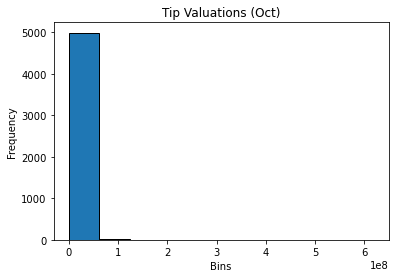

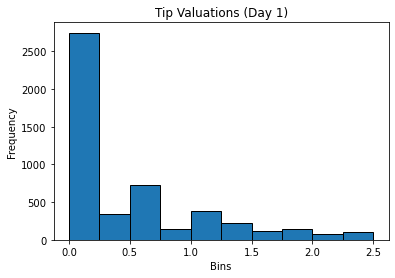

In [7]:
#get values, get rid of outliers, grab 5000 random results
my_tips_val_oct=list(final_dataframe_oct.tip_valuations)
o_tip_hi=np.percentile(my_tips_val_oct,90)
o_tip_lo=np.percentile(my_tips_val_oct,10)
my_tips_val_oct=[x for x in my_tips_val_oct if (x < o_tip_hi) & (x > o_tip_lo)]
oct_trim=random_index_generator(my_tips_val_oct,5000)

#create the plotting objects
fig = plt.figure()
ax = plt.axes()

plt.hist(oct_trim,ec='black')
ax.set_title('Tip Valuations (Oct)')
ax.set_ylabel('Frequency')
ax.set_xlabel('Bins');
#plt.savefig('tip_valuations.png')




#get values, get rid of outliers, grab 5000 random results
my_tips_val_d1=list(final_dataframe_d1.valuations_tip)
d1_tip_hi=np.percentile(my_tips_val_d1,90)
d1_tip_lo=np.percentile(my_tips_val_d1,10)
my_tips_val_d1=[x for x in my_tips_val_d1 if (x < d1_tip_hi) & (x > d1_tip_lo)]
d1_trim=random_index_generator(my_tips_val_d1,5000)



fig2 = plt.figure()
ax2 = plt.axes()

plt.hist(d1_trim,ec='black')
ax2.set_title('Tip Valuations (Day 1)')
ax2.set_ylabel('Frequency')
ax2.set_xlabel('Bins');


#print([round[x] for x in final_dataframe_oct.geth_reccomendation][0:5])

print(len([x for x in oct_trim if x>1]))
print(len([x for x in final_dataframe_oct.max_priority_fee_per_gas if x>1.000000e+09])\
     /len(final_dataframe_oct.max_priority_fee_per_gas))

## Plot the distribution of tips in comparison to the min tip to get accepted into the block

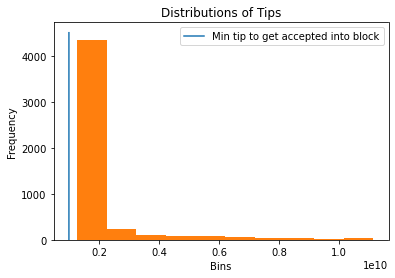

In [8]:

#[round[x] for x in list(final_dataframe_oct.geth_recommendation_tip)]
#display(final_dataframe_oct)
list(final_dataframe_oct.geth_recommendation_tip)[0:5]


y=np.linspace(0,4500,10000)
x=[1000000000.0 for x in range(len(y))]
oct_tips=list(final_dataframe_oct.max_priority_fee_per_gas)

trimmed_tips=outlier_trimmer(90,10,oct_tips)
trimmed_tips=random_index_generator(trimmed_tips,5000)



fig = plt.figure()
ax = plt.axes()
plt.plot(x,y, label='Min tip to get accepted into block')
plt.hist(trimmed_tips)
ax.set_xlabel('Bins')
ax.set_ylabel('Frequency')
ax.set_title('Distributions of Tips')
ax.legend();



,block_number,size,gas_limit,gas_used,timestamp,base_fee_per_gas
0,12965400,52195,27767214,8026699,1628172530,100260964379
1,12965401,133741,27740099,24776018,1628172535,94973980561
2,12965402,4899,27713011,1376999,1628172548,104308692426
3,12965403,91889,27740073,22128780,1628172552,92565823707
4,12965404,158870,27712985,27706025,1628172557,99455472742
...,...,...,...,...,...,...
4995,12969995,14101,29911883,8551333,1628233612,27835081614
4996,12969996,97102,29941092,29930389,1628233614,26345098584
4997,12969997,40406,29970330,8695285,1628233629,29635881520
4998,12969998,64007,29999596,14596008,1628233636,28080959215


14996628


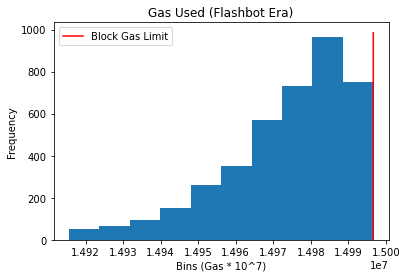

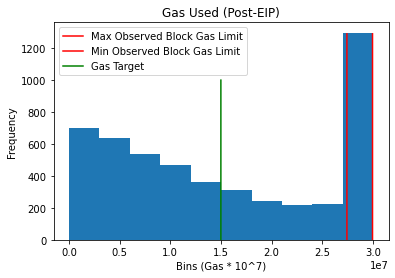

In [9]:
#display(suite_blx)

fig = plt.figure()
ax = plt.axes()
#plt.hist(suite_blx.gas_used)





#get values, get rid of outliers, grab 5000 random results
suite_up=np.percentile(suite_blx.gas_used,90)
suite_lo=np.percentile(suite_blx.gas_used,10)
some_suite_blx=[x for x in suite_blx.gas_used if (x>suite_lo)&(x<suite_up)]
some_suite_blx=random_index_generator(some_suite_blx,4000)



#generate max block limit line
y_s_max_line=np.linspace(0,985,10000)
x_s_max_line=[14996628 for x in range(len(y_s_max_line))]



#get rid of outliers
#post_up=np.percentile(block_data_d1.gas_used,90)
#post_lo=np.percentile(block_data_d1.gas_used,10)
#post_blx=[x for x in block_data_d1.gas_used if (x<post_up)&(x>post_lo)]


#plot the objects
plt.hist(some_suite_blx)
plt.plot(x_s_max_line,y_s_max_line,color='red',label='Block Gas Limit')
ax.set_title('Gas Used (Flashbot Era)')
ax.set_xlabel('Bins (Gas * 10^7)')
ax.set_ylabel('Frequency')
ax.legend(loc='upper left')
plt.savefig('gas_used_sweet_spot')


fig2 = plt.figure()
ax2 = plt.axes()
ax2.set_title('Gas Used (Post-EIP)')
ax2.set_xlabel('Bins (Gas * 10^7)')
ax2.set_ylabel('Frequency')


#generate the max block limit lines
y_max_line=np.linspace(0,1290,10000)
x_max_line=[29970330 for x in range(len(y_max_line))]


y_min_line=np.linspace(0,1290,10000)
x_min_line=[np.min(block_data_d1.gas_limit) for x in range(len(y_min_line))]


y_g_target=np.linspace(0,1000,10000)
x_g_target=[15000000 for x in range(len(y_g_target))]


#plot the objects
plt.hist(block_data_d1.gas_used)
plt.plot(x_max_line,y_max_line,label='Max Observed Block Gas Limit',color='red')
plt.plot(x_min_line,y_min_line,label='Min Observed Block Gas Limit',color='red')
plt.plot(x_g_target,y_g_target,label='Gas Target',color='green')
plt.savefig('gas_used_post_eip')
ax2.legend(loc='upper left')
plt.savefig('Gas_used_post_eip')
#fig = plt.figure()
#ax = plt.axes()
#hist(suite_blx)
#print(len(post_blx))
display(block_data_d1)
print(max(some_suite_blx))

Get the gas used per block from the pre EIP data (takes like 5 minutes), because we dont have proper block data from this time period.

In [10]:
display(pre_geth)


my_blocks=list(set(pre_geth.block_number))
gas_used_in_block=[]

for i in my_blocks:
    current_itteration=pre_geth[pre_geth.block_number == i]
    gas_used_in_block.append(np.sum(current_itteration.receipt_gas_used))
    
pre_eip_gas_used=pd.DataFrame({'block_number':my_blocks,'gas_used': \
                               gas_used_in_block})
display(pre_eip_gas_used)

,hash,block_number,block_timestamp,receipt_gas_used,gas_price
0,0xc9d37faf9270c0aa1a553d4e53777cf1617a606d8a26...,12111333,2021-03-26 00:16:51 UTC,45764,129000000000
1,0xceeee703a7638bfa1eaa0c3d97f31fe211dfb77915e6...,12111413,2021-03-26 00:33:17 UTC,36601,168000000000
2,0x87007e41f34e2c1ea51fe9ff5bde4a039c70f2a218fe...,12111458,2021-03-26 00:42:19 UTC,21000,174000000000
3,0x497a2de3a8a8a2799ead2bb558ba072cbb50c1f2ab8a...,12111280,2021-03-26 00:06:07 UTC,154315,168211840178
4,0x548aa6b360f2b81f0ed437b35af5405dfce857069e71...,12111328,2021-03-26 00:15:32 UTC,21000,154000000000
...,...,...,...,...,...
6264787,0xac03a458748d87b1e03732c7a60f13d3f6278e2dfb84...,12088722,2021-03-22 12:53:38 UTC,21000,165000000000
6264788,0xa10fa129bc83a7d7b85391b7c85ae579b3ab59ef6fd0...,12088822,2021-03-22 13:15:19 UTC,21000,213000000000
6264789,0xa43bb8f1b1d77b3f9770311998bc667e4e393e022021...,12085526,2021-03-22 00:58:55 UTC,112866,181000000000
6264790,0x5a90c80b066cd7577c71ee1e891353535d6e5f16f75c...,12087380,2021-03-22 07:54:46 UTC,21000,6000000000


,block_number,gas_used
0,12085254,12505492
1,12085255,12494633
2,12085256,12501913
3,12085257,12490684
4,12085258,12493393
...,...,...
30603,12116287,12458589
30604,12116288,12455980
30605,12116289,12410905
30606,12116290,12450340


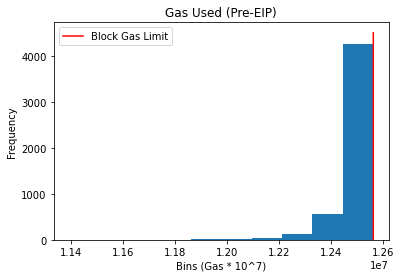

In [11]:

fig = plt.figure()
ax = plt.axes()

#get the gas used
pre_gas_used=list(pre_eip_gas_used.gas_used)


#trim outliers
#oct_up=np.percentile(pre_gas_used,90)
#oct_lo=np.percentile(pre_gas_used,10)
#pre_gas_used=[x for x in pre_gas_used if (x<oct_up)&(x>oct_lo)]
smaller_pre_gas=random_index_generator(pre_gas_used,5000)


#generate the max block gas limits
y_pre_max_line=np.linspace(0,4500,10000)
x_pre_max_line=[np.max(smaller_pre_gas) for x in range(len(y_pre_max_line))]


#plot the max gas limits
plt.hist(smaller_pre_gas)
plt.plot(x_pre_max_line,y_pre_max_line,label='Block Gas Limit',color='red')

#generate the titles
ax.set_title('Gas Used (Pre-EIP)')
ax.set_xlabel('Bins (Gas * 10^7)')
ax.set_ylabel('Frequency')
ax.legend(loc='upper left')
plt.savefig('gas_used_pre_eip')


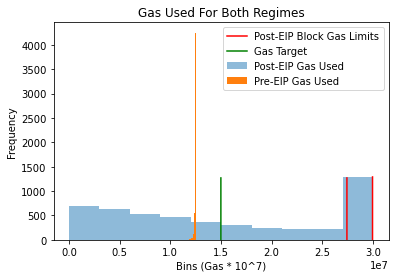

In [12]:
fig = plt.figure()
ax = plt.axes()

#plot three histograms
plt.hist(block_data_d1.gas_used,label='Post-EIP Gas Used',alpha=0.5)
plt.hist(smaller_pre_gas,label='Pre-EIP Gas Used')
#plt.hist(some_suite_blx,label='Pre-EIP (Sweet Spot) Gas Used')

#generate max block limit lines
y_max_line=np.linspace(0,1290,10000)
x_max_line=[29970330 for x in range(len(y_max_line))]

y_min_line=np.linspace(0,1270,10000)
x_min_line=[np.min(block_data_d1.gas_limit) for x in range(len(y_min_line))]


y_g_target=np.linspace(0,1270,10000)
x_g_target=[15000000 for x in range(len(y_g_target))]

#plot max block gas limits 
plt.plot(x_max_line,y_max_line,label='Post-EIP Block Gas Limits',color='red')
plt.plot(x_min_line,y_min_line,color='red')
plt.plot(x_g_target,y_g_target,label='Gas Target',color='green')
#set margins so legend is visible
#plt.ylim(0,1000)
ax.legend(loc='upper right')
ax.set_title('Gas Used For Both Regimes')
ax.set_xlabel('Bins (Gas * 10^7)')
ax.set_ylabel('Frequency');
plt.savefig('both_regimes.png')